In [28]:
import numpy as np

In [29]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None
    
    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)
        
        #Scatter classes
        mean_total = np.mean(X, axis= 0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))

        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis= 0)
            SW += (X_c - mean_c).T @ (X_c - mean_c)

            samples_inclass = X_c.shape[0]
            mean_difference = (mean_c - mean_total).reshape((n_features, 1))
            SB += samples_inclass * mean_difference @ mean_difference.T

        vector = np.linalg.inv(SW) @ SB
        eigenvalues, eigenvectors = np.linalg.eig(vector)
        eigenvectors = eigenvectors.T
        indices = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[indices]
        self.linear_discriminants = eigenvectors[:self.n_components]

    def transform(self, X):
        return X @ self.linear_discriminants.T

In [30]:
import pandas as pd

In [31]:
dataset = pd.read_excel('Muscular_Data.xlsx')
target_column = dataset['Carrier']
independent_variables = dataset.drop('Carrier', axis = 1)
independent_variables['Pyrovate_Kinase'].fillna(independent_variables['Pyrovate_Kinase'].median(), inplace = True)
muscleDataFrame = independent_variables.join(pd.Series(target_column, name = 'class'))

In [33]:
X = muscleDataFrame.iloc[:, :4].to_numpy()
y = muscleDataFrame.iloc[:, 4].to_numpy()

In [34]:
lda = LDA(n_components= 2)
lda.fit(X, y)
X_transformed = lda.transform(X)

In [35]:
x1 = X_transformed[:, 0]
x2 = X_transformed[:, 1]

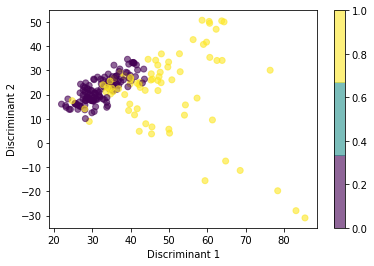

In [36]:
plt.scatter(x1, x2, c= y, alpha= 0.6,
            cmap= plt.cm.get_cmap('viridis', 3))
plt.xlabel('Discriminant 1')
plt.ylabel('Discriminant 2')
plt.colorbar()
plt.show()